In [43]:
import numpy as np
import re
import os
import pandas as pd

%pylab inline --no-import-all



#colors from http://phrogz.net/css/distinct-colors.html
colors = "#7f0000, #ffea00, #00f2e2, #1a3366, #990030, #d94f00, #95a600, #008077, #52008c, #f23d76, #733f00, #47cc00, #40c6ff, #b000e6, #d9001d, #e59839, #246600, #1a4f66, #f23db9, #8c7023, #00b365, #366cd9, #802061".split(", ")
print colors


Populating the interactive namespace from numpy and matplotlib
['#7f0000', '#ffea00', '#00f2e2', '#1a3366', '#990030', '#d94f00', '#95a600', '#008077', '#52008c', '#f23d76', '#733f00', '#47cc00', '#40c6ff', '#b000e6', '#d9001d', '#e59839', '#246600', '#1a4f66', '#f23db9', '#8c7023', '#00b365', '#366cd9', '#802061']


In [45]:




def GetData(filename):
    matrix = pd.read_csv(filename, skipinitialspace=True)
    #print matrix.columns
    #means = matrix.groupby('p').mean()
    
    #stdevs = matrix.groupby('p').std()
 
    return (matrix)
 
def GetStrongScaling(pdSerie,matrixname,outdirpgf='',outdirpdf=''):

    means = pdSerie.groupby('p').mean()
    stdevs = pdSerie.groupby('p').std()
    columns = means.columns.values.tolist()
    print means
    
    subfig = plt.figure()
    subfig.set_size_inches(9,6)
    ax = subfig.add_subplot(111)

    ax.set_title('Running times for %s' % matrixname,fontsize=25)
    ax.set_xlabel('Processor count');
    ax.set_ylabel('Time (s)');    
    
    
    for col in columns:
        hasErrorBar = np.all(stdevs[col].notnull())
        if(hasErrorBar):
            ax.errorbar(means.index, means[col], yerr=stdevs[col], label=col,linewidth=3,markersize=8) 
        else:
            ax.plot(means.index, means[col], label=col,linewidth=3,markersize=8)
    
    #setup axis limits
    maxX = means.index.max()
    minX = means.index.min()
    maxY = np.nanmax(means.values)
    minY = np.nanmin(means.values)
    
    print minX,maxX,minY,maxY
    
    ax.set_ylim([0.5*minY,maxY])
    #ax.set_yscale('log')
    ax.set_xlim([0.8*minX,1.2*maxX])
    ax.set_xscale('log',xbase=2)
    
    #setup axis labels and ticks

    ax.set_xticks(means.index)
    if(ax.get_xscale=='log'):
        ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticklabels(means.index,rotation=45,ha='right')
    
    if(ax.get_yscale=='log'):
        #ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    showLegend = True
    if(showLegend):
        #legend = ax.legend(loc='lower left', shadow=True)
        legend = ax.legend(loc='upper right', shadow=True)
        frame  = legend.get_frame()
        frame.set_facecolor('1')
    
    
    #increase font sizes
    for item in ([ax.title, ax.xaxis.label,ax.yaxis.label]):
        item.set_fontsize(20)
        
    for item in (ax.get_xticklabels()+ax.get_yticklabels()):
        item.set_fontsize(15)
        
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

    #output files if necessary
    if(len(outdirpgf)>0):
        if(not os.path.isdir(outdirpgf)):
            os.makedirs(outdirpgf)
        subfig.savefig('%s/ss_%s.pgf'%(outdirpgf,matrixname),transparent=True) 
        
    if(len(outdirpdf)>0):       
        if(not os.path.isdir(outdirpdf)):
            os.makedirs(outdirpdf)
        subfig.savefig('%s/ss_%s.pdf'%(outdirpdf,matrixname))


    return subfig,ax

def GetLegend(ax,matrixname,outdirpgf='',outdirpdf=''):
    
    fig2=plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.set_axis_off()
    #plt.axis('off')
    (handles,labels) = ax.get_legend_handles_labels()
    #customize labels if necessary
    labels_new = labels #[u"Super LU",u'PSelInv   Binary Tree',u'PSelInv   Flat-Tree',u'PSelInv 0.7.3   Flat-Tree',u'PSelInvfgShifted Binary Tree']
    
    legend2 = ax2.legend(handles,labels_new, loc='center', shadow=False,ncol=3)
    
    frame2  = legend2.get_frame()
    frame2.set_facecolor('1')
    # Set the fontsize
    for label in legend2.get_texts():
        label.set_fontsize(15)

    for label in legend2.get_lines():
        label.set_linewidth(1.5)  # the legend line width

    #plt.tight_layout()#pad=0.2, w_pad=2, h_pad=0.5)
    #plt.subplots_adjust(left=1, right=1, top=1, bottom=0.5)
    fig2.subplots_adjust(bottom=0.1, hspace = 0.2)
    
    #legend2.get_frame().set_color('0.70')
    #fig2.canvas.draw()
    ax2.set_adjustable('datalim')
    
    #output files if necessary
    if(len(outdirpgf)>0):
        if(not os.path.isdir(outdirpgf)):
            os.makedirs(outdirpgf)
        fig2.savefig('%s/ss_legend_%s.pgf'%(outdirpgf,matrixname),transparent=True,additional_artists=legend2,bbox_inches="tight") 
        
    if(len(outdirpdf)>0):       
        if(not os.path.isdir(outdirpdf)):
            os.makedirs(outdirpdf)
        fig2.savefig('%s/ss_legend_%s.pdf'%(outdirpdf,matrixname),additional_artists=legend2,bbox_inches="tight")

    return fig2,ax2


def GetMappingImpact(pdSerie,matrixname,outdirpgf='',outdirpdf=''):

    means = pdSerie.groupby(['ordering','mapping','p']).mean()
    #stdevs = pdSerie.groupby('p').std()
   
    #remove one level (p)
    means = means.reset_index(level=2)

    
    levels = means.index.names
    indexes = np.unique(means.index.ravel())

    
   
        
    print means.index.levels[0]
    
    for ordering in means.index.levels[0]:
        
        subfig = plt.figure()
        subfig.set_size_inches(9,6)
        ax = subfig.add_subplot(111)

        ax.set_title('Total communication volume for %s' % matrixname,fontsize=25)
        ax.set_xlabel('Processor count');
        ax.set_ylabel('Volume (bytes)');         
        
        for mapping in means.index.levels[1]:
            serie = means.xs((ordering,mapping),level=levels)
            #print serie
            curlabel = ("%s - %s" % (mapping,ordering))
            filename = ("%s_%s_%s" % (matrixname,mapping,ordering))
            ax.plot(serie["p"], serie["volume"], label=curlabel,linewidth=3,markersize=8)
        
#    print means.xs(('AMD','ROW2D'), level=('ordering','mapping'))

    
#     for col in columns:
#         hasErrorBar = np.all(stdevs[col].notnull())
#         if(hasErrorBar):
#             ax.errorbar(means.index, means[col], yerr=stdevs[col], label=col,linewidth=3,markersize=8) 
#         else:
#             ax.plot(means.index, means[col], label=col,linewidth=3,markersize=8)
    
#     #setup axis limits
#     maxX = means.index.max()
#     minX = means.index.min()
#     maxY = np.nanmax(means.values)
#     minY = np.nanmin(means.values)
    
#     print minX,maxX,minY,maxY
    
#     ax.set_ylim([0.5*minY,maxY])
#     #ax.set_yscale('log')
#     ax.set_xlim([0.8*minX,1.2*maxX])
#     ax.set_xscale('log',xbase=2)
    
#     #setup axis labels and ticks

#     ax.set_xticks(means.index)
#     if(ax.get_xscale=='log'):
#         ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
#     ax.set_xticklabels(means.index,rotation=45,ha='right')
    
#     if(ax.get_yscale=='log'):
#         #ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
#         ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
        showLegend = True
        if(showLegend):
            legend = ax.legend(loc='lower right', shadow=True)
            #legend = ax.legend(loc='upper right', shadow=True)
            frame  = legend.get_frame()
            frame.set_facecolor('1')
    
    
        #increase font sizes
        for item in ([ax.title, ax.xaxis.label,ax.yaxis.label]):
            item.set_fontsize(20)

        for item in (ax.get_xticklabels()+ax.get_yticklabels()):
            item.set_fontsize(15)

        plt.tick_params(axis='both', which='major', labelsize=14)

        plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

        #output files if necessary
        if(len(outdirpgf)>0):
            if(not os.path.isdir(outdirpgf)):
                os.makedirs(outdirpgf)
            subfig.savefig('%s/ss_%s.pgf'%(outdirpgf,filename),transparent=True) 

        if(len(outdirpdf)>0):       
            if(not os.path.isdir(outdirpdf)):
                os.makedirs(outdirpdf)
            subfig.savefig('%s/ss_%s.pdf'%(outdirpdf,filename))


#     return subfig,ax


def GetLBMappingImpact(pdSerie,matrixname,outdirpgf='',outdirpdf=''):

    means = pdSerie.groupby(['ordering','load_balancing','mapping','p']).mean()
    #stdevs = pdSerie.groupby('p').std()
   
    #remove one level (p)
    means = means.reset_index(level=3)

    
    levels = means.index.names
    indexes = np.unique(means.index.ravel())

    
   
        
    print means.index.levels[0]
    
    for ordering in means.index.levels[0]:
        
        subfig = plt.figure()
        subfig.set_size_inches(9,6)
        ax = subfig.add_subplot(111)

        ax.set_title('Total communication volume for %s' % matrixname,fontsize=25)
        ax.set_xlabel('Processor count');
        ax.set_ylabel('Volume (bytes)');         
        
        i=0
        for lb in means.index.levels[1]:
            for mapping in means.index.levels[2]:
                color = colors[i%len(colors)]
                serie = means.xs((ordering,lb,mapping),level=levels)
                #print serie
                curlabel = ("%s - %s - %s" % (mapping,lb,ordering))
                filename = ("%s_%s_%s_%s" % (matrixname,mapping,lb,ordering))
                ax.plot(serie["p"], serie["volume"], label=curlabel,linewidth=3,markersize=8,color=color)
                i+=1

#    print means.xs(('AMD','ROW2D'), level=('ordering','mapping'))

    
#     for col in columns:
#         hasErrorBar = np.all(stdevs[col].notnull())
#         if(hasErrorBar):
#             ax.errorbar(means.index, means[col], yerr=stdevs[col], label=col,linewidth=3,markersize=8) 
#         else:
#             ax.plot(means.index, means[col], label=col,linewidth=3,markersize=8)
    
#     #setup axis limits
#     maxX = means.index.max()
#     minX = means.index.min()
#     maxY = np.nanmax(means.values)
#     minY = np.nanmin(means.values)
    
#     print minX,maxX,minY,maxY
    
#     ax.set_ylim([0.5*minY,maxY])
#     #ax.set_yscale('log')
#     ax.set_xlim([0.8*minX,1.2*maxX])
#     ax.set_xscale('log',xbase=2)
    
#     #setup axis labels and ticks

#     ax.set_xticks(means.index)
#     if(ax.get_xscale=='log'):
#         ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
#     ax.set_xticklabels(means.index,rotation=45,ha='right')
    
#     if(ax.get_yscale=='log'):
#         #ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
#         ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
        showLegend = True
        if(showLegend):
            #legend = ax.legend(loc='lower right', shadow=True)
            #legend = ax.legend(loc='upper right', shadow=True)
            # Put a legend below current axis
            legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=2) 
            frame  = legend.get_frame()
            frame.set_facecolor('1')
        
   
    
        #increase font sizes
        for item in ([ax.title, ax.xaxis.label,ax.yaxis.label]):
            item.set_fontsize(20)

        for item in (ax.get_xticklabels()+ax.get_yticklabels()):
            item.set_fontsize(15)

        plt.tick_params(axis='both', which='major', labelsize=14)

        plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

        #output files if necessary
        if(len(outdirpgf)>0):
            if(not os.path.isdir(outdirpgf)):
                os.makedirs(outdirpgf)
            subfig.savefig('%s/ss_%s.pgf'%(outdirpgf,filename),transparent=True) 

        if(len(outdirpdf)>0):       
            if(not os.path.isdir(outdirpdf)):
                os.makedirs(outdirpdf)
            subfig.savefig('%s/ss_%s.pdf'%(outdirpdf,filename))


#     return subfig,ax


def GetLBMappingImpactTime(pdSerie,matrixname,outdirpgf='',outdirpdf=''):

    means = pdSerie.groupby(['ordering','load_balancing','mapping','p']).mean()
    #stdevs = pdSerie.groupby('p').std()
   
    #remove one level (p)
    means = means.reset_index(level=3)

    
    levels = means.index.names
    indexes = np.unique(means.index.ravel())

    
   
        
    print means.index.levels[0]
    
    for ordering in means.index.levels[0]:
        
        subfig = plt.figure()
        subfig.set_size_inches(9,6)
        ax = subfig.add_subplot(111)

        ax.set_title('Total time for %s' % matrixname,fontsize=25)
        ax.set_xlabel('Processor count');
        ax.set_ylabel('Time (s)');         
        
        i=0
        for lb in means.index.levels[1]:
            for mapping in means.index.levels[2]:
                color = colors[i%len(colors)]
                serie = means.xs((ordering,lb,mapping),level=levels)
                #print serie
                curlabel = ("%s - %s - %s" % (mapping,lb,ordering))
                filename = ("%s_%s_%s_%s" % (matrixname,mapping,lb,ordering))
                ax.plot(serie["p"], serie["time"], label=curlabel,linewidth=3,markersize=8,color=color)
                i+=1

#    print means.xs(('AMD','ROW2D'), level=('ordering','mapping'))

    
#     for col in columns:
#         hasErrorBar = np.all(stdevs[col].notnull())
#         if(hasErrorBar):
#             ax.errorbar(means.index, means[col], yerr=stdevs[col], label=col,linewidth=3,markersize=8) 
#         else:
#             ax.plot(means.index, means[col], label=col,linewidth=3,markersize=8)
    
#     #setup axis limits
#     maxX = means.index.max()
#     minX = means.index.min()
#     maxY = np.nanmax(means.values)
#     minY = np.nanmin(means.values)
    
#     print minX,maxX,minY,maxY
    
#     ax.set_ylim([0.5*minY,maxY])
        ax.set_yscale('log')
#     ax.set_xlim([0.8*minX,1.2*maxX])
#     ax.set_xscale('log',xbase=2)
    
#     #setup axis labels and ticks

#     ax.set_xticks(means.index)
#     if(ax.get_xscale=='log'):
#         ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
#     ax.set_xticklabels(means.index,rotation=45,ha='right')
    
#     if(ax.get_yscale=='log'):
#         #ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
#         ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
        showLegend = True
        if(showLegend):
            #legend = ax.legend(loc='lower right', shadow=True)
            #legend = ax.legend(loc='upper right', shadow=True)
            # Put a legend below current axis
            legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=2) 
            frame  = legend.get_frame()
            frame.set_facecolor('1')
        
   
    
        #increase font sizes
        for item in ([ax.title, ax.xaxis.label,ax.yaxis.label]):
            item.set_fontsize(20)

        for item in (ax.get_xticklabels()+ax.get_yticklabels()):
            item.set_fontsize(15)

        plt.tick_params(axis='both', which='major', labelsize=14)

        plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

        #output files if necessary
        if(len(outdirpgf)>0):
            if(not os.path.isdir(outdirpgf)):
                os.makedirs(outdirpgf)
            subfig.savefig('%s/ss_%s.pgf'%(outdirpgf,filename),transparent=True) 

        if(len(outdirpdf)>0):       
            if(not os.path.isdir(outdirpdf)):
                os.makedirs(outdirpdf)
            subfig.savefig('%s/ss_%s.pdf'%(outdirpdf,filename))




Index([u'SCOTCH'], dtype='object', name=u'ordering')
Index([u'SCOTCH'], dtype='object', name=u'ordering')
Index([u'SCOTCH'], dtype='object', name=u'ordering')


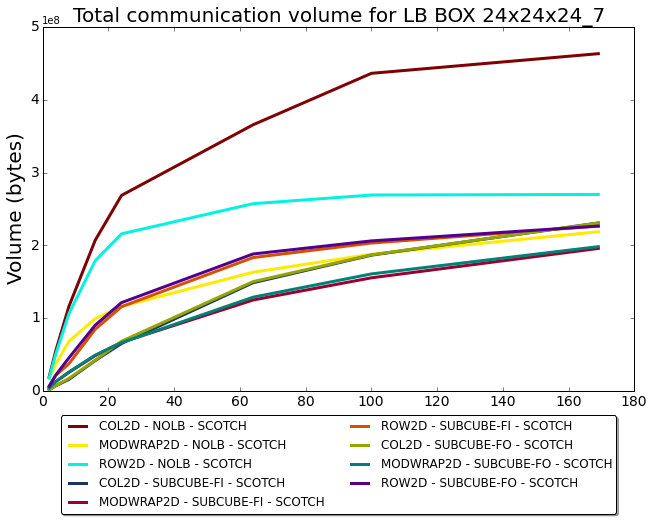

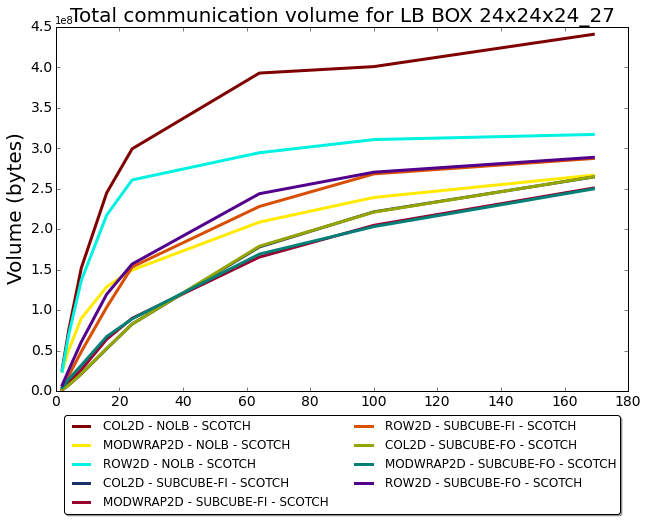

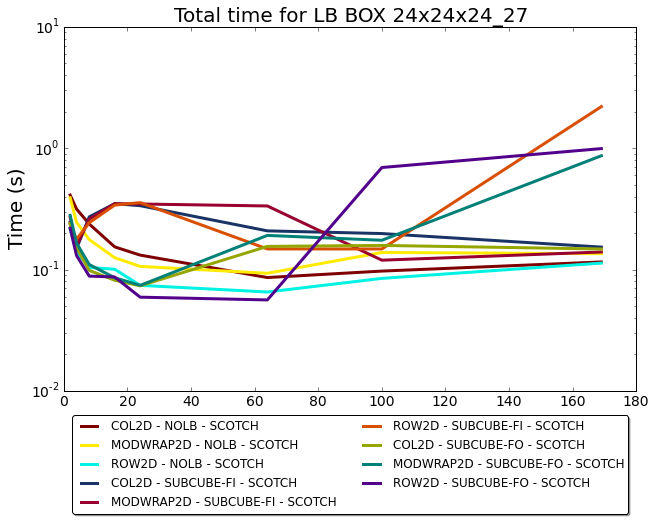

In [46]:
impact = GetData('../Results/lb_cost_impact.24x24x24_7.csv') 
GetLBMappingImpact(impact,'LB BOX 24x24x24_7','pgf','pdf')

impact = GetData('../Results/lb_cost_impact.24x24x24_27.csv') 
GetLBMappingImpact(impact,'LB BOX 24x24x24_27','pgf','pdf')

impact = GetData('../Results/lb_time_impact.24x24x24_27.csv') 
GetLBMappingImpactTime(impact,'LB BOX 24x24x24_27','pgf','pdf')


Index([u'AMD', u'METIS', u'MMD', u'NDBOX', u'SCOTCH'], dtype='object', name=u'ordering')


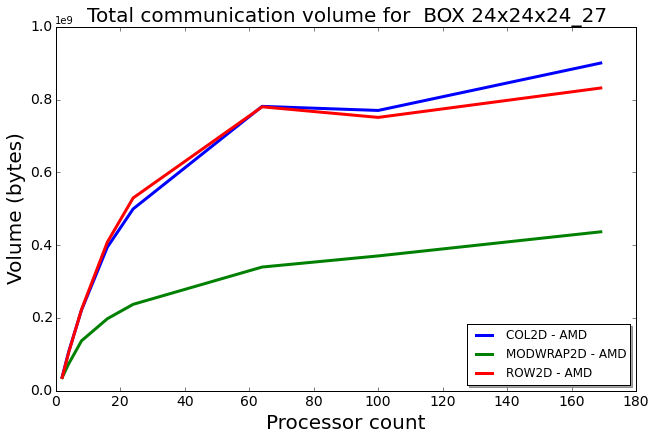

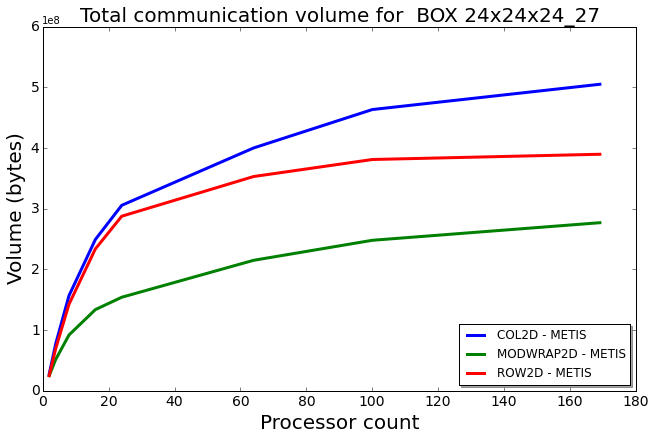

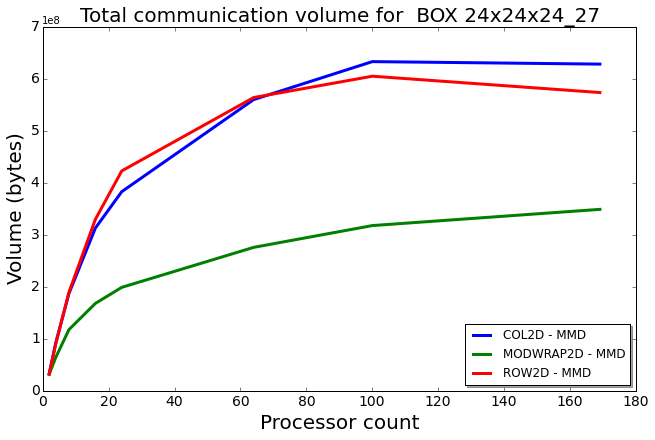

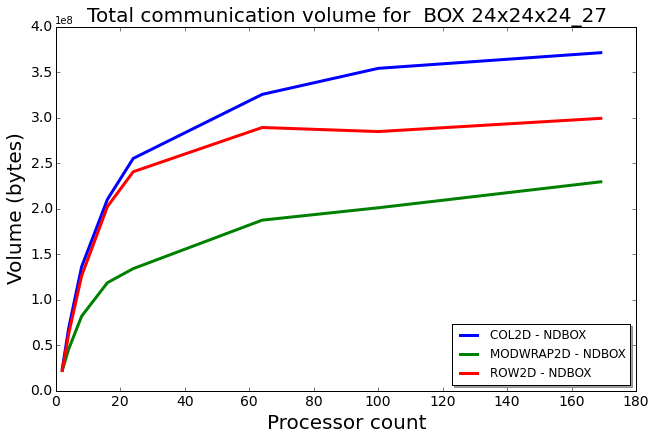

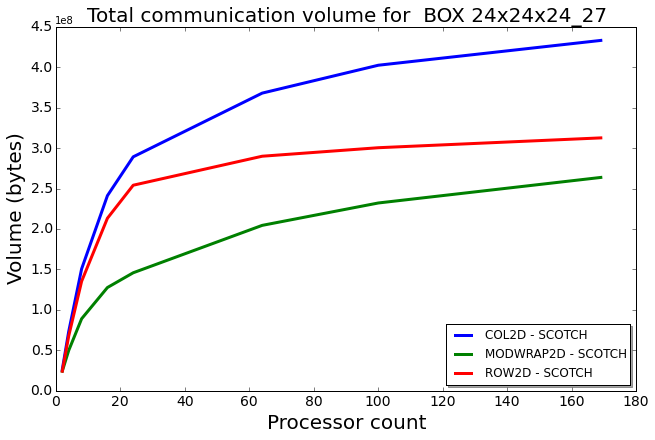

In [3]:
impact = GetData('../Results/mapping_impact.csv') 
GetMappingImpact(impact,' BOX 24x24x24_27','pgf','pdf')

In [90]:
pwtk = GetData('09-28-2015/Pwtk_100_SUBCUBE-FI.csv') 
fig,ax = GetStrongScaling(pwtk,'pwtk','pgf')
legend,axl = GetLegend(ax,'pwtk')

IOError: File 09-28-2015/Pwtk_100_SUBCUBE-FI.csv does not exist

     MUMPS 5.0  ROW2D (PUSH)  COL2D (PULL)  COL2D (PUSH)  ROW2D (PULL)
p                                                                     
1     25.18520      30.07830      30.13120      30.07610      30.02340
4      9.03824      34.72370      32.67070      32.54740      27.68560
16     3.09027      12.68260       9.02774       9.53376       9.29603
24     2.47243       9.37082       5.50689       5.96186       5.71889
64     1.26904       5.36592       2.57689       3.30580       3.30101
96     1.12049       3.51778       1.85518       2.75947       2.06195
128    1.16218       2.85346       1.61054       2.61304       1.55044
192    1.39719       2.06596       1.43103       2.62690       1.34668
256    1.78964       1.93586       1.39896       2.43894       1.31036
384    2.27731       1.63204       1.31971       2.62603       1.29920
576    3.80856       1.36675       1.27879       2.97002       1.25681
1 576 1.12049 34.7237


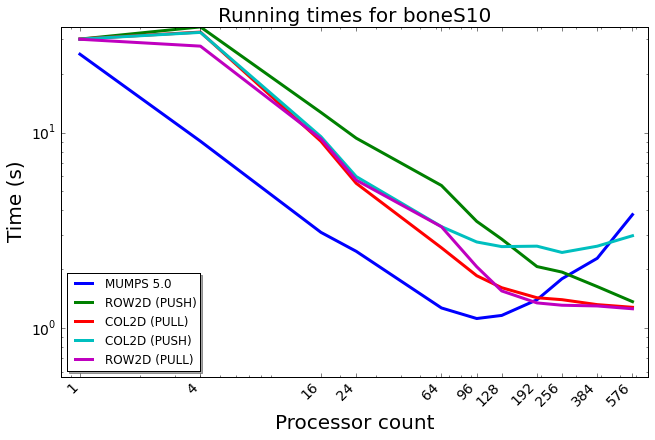

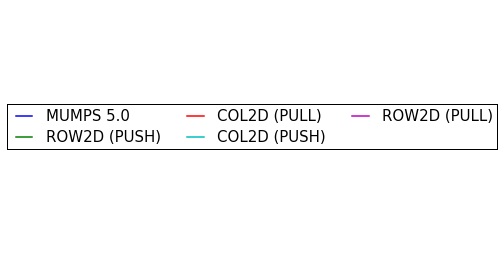

In [179]:
data = GetData('09-28-2015/BoneS10_100_SUBCUBE-FI.csv') 
fig,ax = GetStrongScaling(data,'boneS10','pgf')
legend,axl = GetLegend(ax,'boneS10')

     MUMPS 5.0  ROW2D (PUSH)  COL2D (PULL)  COL2D (PUSH)  ROW2D (PULL)
p                                                                     
64     15.1306       48.2920       38.3357      14.51050      11.46990
96     11.2019       52.3446       33.2853      12.28200       8.70294
128     9.4787       51.6602       31.8036      11.27880       7.39072
192    10.3383       33.3800       26.1185       9.70353       6.38843
256    10.6987       43.2681       23.0006       9.77755       6.31677
384    14.5382       41.9468       19.0525       9.77189       5.68708
576    15.7218       17.7700       15.9441      10.58770       5.62318
64 576 5.62318 52.3446


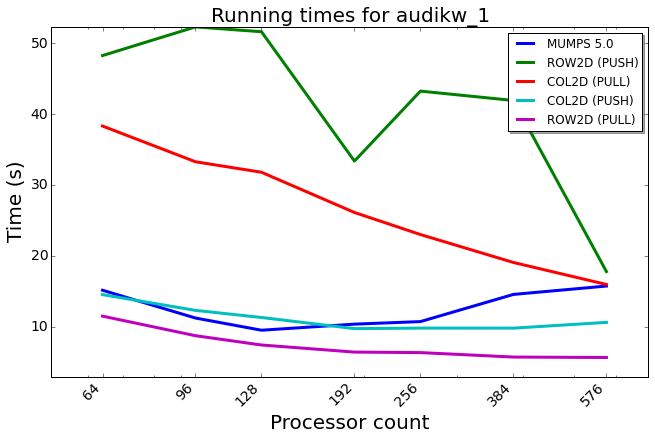

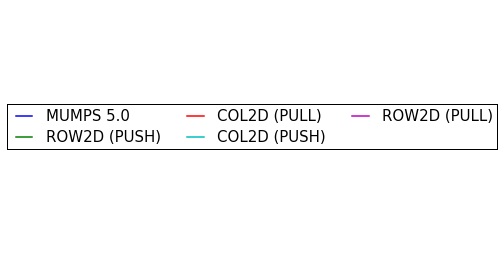

In [186]:
data = GetData('09-28-2015/Audikw_1_100_SUBCUBE-FI.csv') 
fig,ax = GetStrongScaling(data,'audikw_1','pgf')
legend,axl = GetLegend(ax,'audikw_1')

Results/boneS10/03-10-2015
         p      mw2d     col2d     row2d   mumps5    diag2d
1        1  53.95030  51.79370  51.74780  42.8636  53.88060
4        4  25.93610  24.13220  38.90720  15.2197  25.90880
8        8  35.51620  18.25860  39.57000  11.6518  35.52990
16      16  14.45080  11.00480  15.82080   6.4754  14.39300
24      24  15.49600   9.51345  16.37760   4.2196  15.49220
32      32  15.97040   7.45434  13.86120   3.7032  16.05910
48      48  14.54800   5.88524  13.08910   2.6683  14.54290
64      64   9.17541   5.09268   8.40761   2.4348   9.18722
72      72   9.84013   5.07454   7.65348   2.8230   9.84643
96      96   7.29907   3.82560   5.19922   2.1171   7.23546
120    120   7.90434   3.60940   3.92811   3.3873       NaN
128    128   6.34502   4.20051   4.17426   2.3909       NaN
192    192   5.05849   2.65932   2.91743   2.3774       NaN
256    256   4.41311   2.22664   2.34188   1.8624       NaN
384    384   5.59860   2.06906   1.96419   3.3255       NaN
512    512   

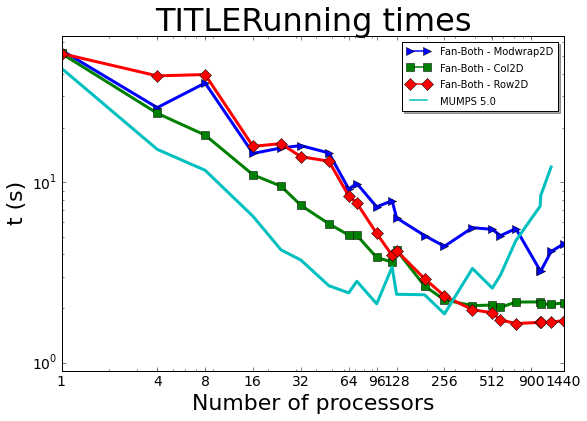

In [16]:



# parse data files
datafile='Results/boneS10/03-10-2015/perf_all_variants.dat'
datapath = os.path.dirname(datafile)
matrixname = 'BoneS10'

print datapath

dt = np.dtype([('p', int), ('mw2d',float), ('col2d', float), ('row2d', float) , ('mumps5', float), ('diag2d', float)])

data=np.zeros((0,),dt)

with open(datafile) as f1:
    for line in f1:
        if line[0] != '#':
            line = re.sub(r'[ ]+', r' ', line).upper()
            line_lst = line.rstrip().split(" ")
            #print line_lst
            line_lst = map(float,line_lst)
            line_lst[0:1] = [int(val) for val in line_lst[0:1]]
            
            line_lst = [None if x==-1 else x for x in line_lst]
            
            #print line_lst
            data.resize(data.shape[0]+1)
            data[-1] = tuple(line_lst)
        
         
    PROCS=data['p']
    MODWRAP2D = data['mw2d']

    COL2D = data['col2d']
    ROW2D = data['row2d']
    MUMPS = data['mumps5']
    DIAG2D = data['diag2d']
    
    df = pd.DataFrame.from_records(data, index=PROCS, columns=['p', 'mw2d','col2d','row2d','mumps5','diag2d'])
    print df
    
    
    #replot into another figure to save the separate thing
    subfig = plt.figure()
    subfig.set_size_inches(9,6)
    ax = subfig.add_subplot(111)
    
    lineMODWRAP2D, = ax.plot(PROCS,MODWRAP2D, '-',marker='>', markersize=8, linewidth=3, label='Fan-Both - Modwrap2D')
    lineCOL2D, = ax.plot(PROCS,COL2D, '-',marker='s', markersize=8, linewidth=3, label='Fan-Both - Col2D')
    lineROW2D, = ax.plot(PROCS,ROW2D, '-',marker='D', markersize=8, linewidth=3, label='Fan-Both - Row2D')
    lineMUMPS, = ax.plot(PROCS,MUMPS, '-', linewidth=3, label='MUMPS 5.0')
    #lineDIAG2D, = ax.plot(PROCS,DIAG2D, '--', linewidth=3, label='Fan-Both - Diag2D')
    
    
    ax.set_xticks(PROCS)
    
    ax.set_title('TITLERunning times',fontsize=32)
    ax.set_xlabel('Number of processors',fontsize=22)
    ax.set_ylabel('t (s)',fontsize=22)
    
    maxy = 0
    miny = float("Inf")
    maxy = max( maxy,np.amax(MODWRAP2D),np.amax(COL2D),np.amax(ROW2D),np.amin(MUMPS),np.amin(DIAG2D) )
    miny = min( miny,np.amin(MODWRAP2D),np.amin(COL2D),np.amin(ROW2D),np.amin(MUMPS),np.amin(DIAG2D) )    
    
    ax.set_yscale('log',xbase=10)
    ax.set_xscale('log',xbase=2)
    ax.set_ylim([0.9,maxy*1.2])
    ax.set_xlim([1,1440])
    
    
    TICKS = [1, 4 , 8, 16, 32, 64, 96, 128, 256, 512, 900, 1440]
    ax.set_xticks(TICKS)
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        

    legend = ax.legend(loc='upper right', shadow=True)
    frame  = legend.get_frame()
    frame.set_facecolor('1')
    
    # Set the fontsize
    for label in legend.get_texts():
            label.set_fontsize(10)
    
    for label in legend.get_lines():
            label.set_linewidth(1.5)  # the legend line width
    
    plt.tick_params(axis='both', which='major', labelsize=14)
        
    subfig.savefig(datapath + '/%s.pdf' % matrixname)
    subfig.savefig(datapath + '/%s.pgf' %matrixname,transparent=True)


Results/boneS10/07-14-2015
         p      mw2d     col2d     row2d  mumps5    diag2d    col2dp  \
16      16  14.45080  11.00480  15.82080  6.4754  14.39300  10.97192   
24      24  15.49600   9.51345  16.37760  4.2196  15.49220   9.69892   
25      25       NaN       NaN       NaN     NaN       NaN       NaN   
32      32  15.97040   7.45434  13.86120  3.7032  16.05910   7.72553   
48      48  14.54800   5.88524  13.08910  2.6683  14.54290   6.24153   
64      64   9.17541   5.09268   8.40761  2.4348   9.18722   5.68815   
96      96   7.29907   3.82560   5.19922  2.1171   7.23546   4.44081   
121    121       NaN       NaN       NaN     NaN       NaN       NaN   
128    128   6.34502   4.20051   4.17426  2.3909       NaN   3.60854   
169    169       NaN       NaN       NaN     NaN       NaN       NaN   
192    192   5.05849   2.65932   2.91743  2.3774       NaN   3.14309   
256    256   4.41311   2.22664   2.34188  1.8624       NaN   2.76013   
361    361       NaN       NaN       

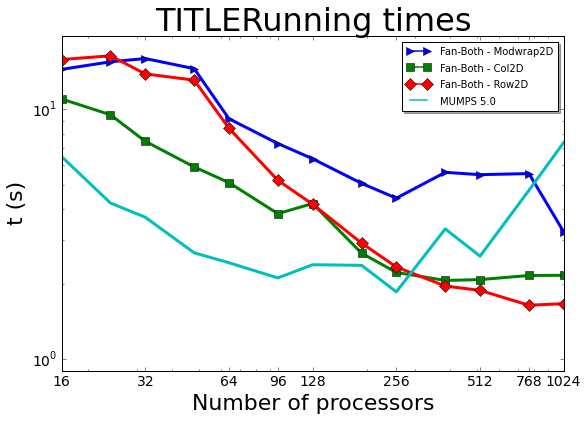

In [35]:



# parse data files
datafile='Results/boneS10/07-14-2015/perf_all_variants.dat'
datapath = os.path.dirname(datafile)
matrixname = 'BoneS10'

print datapath

dt = np.dtype([('p', int), ('mw2d',float), ('col2d', float), ('row2d', float) , ('mumps5', float), ('diag2d', float),('col2dp', float), ('row2dp', float), ('mw2dp', float)])

data=np.zeros((0,),dt)

with open(datafile) as f1:
    for line in f1:
        if line[0] != '#':
            line = re.sub(r'[ ]+', r' ', line).upper()
            line_lst = line.rstrip().split(" ")
            #print line_lst
            line_lst = map(float,line_lst)
            line_lst[0:1] = [int(val) for val in line_lst[0:1]]
            
            line_lst = [None if x==-1 else x for x in line_lst]
            
            #print line_lst
            data.resize(data.shape[0]+1)
            data[-1] = tuple(line_lst)
        
         
    PROCS=data['p']
    MODWRAP2D = data['mw2d']
    COL2D = data['col2d']
    ROW2D = data['row2d']
    MUMPS = data['mumps5']
    DIAG2D = data['diag2d']
    COL2DPULL = data['col2dp']
    ROW2DPULL = data['row2dp']
    MW2DPULL = data['mw2dp']
    s1mask = np.isfinite(ROW2DPULL)
    s2mask = np.isfinite(MW2DPULL)
   
    
    df = pd.DataFrame.from_records(data, index=PROCS, columns=['p', 'mw2d','col2d','row2d','mumps5','diag2d','col2dp','row2dp','mw2dp'])
    print df
    
    
    #replot into another figure to save the separate thing
    subfig = plt.figure()
    subfig.set_size_inches(9,6)
    ax = subfig.add_subplot(111)
    
    lineMODWRAP2D, = ax.plot(PROCS[s1mask],MODWRAP2D[s1mask], '-',marker='>', markersize=8, linewidth=3, label='Fan-Both - Modwrap2D')
    lineCOL2D, = ax.plot(PROCS[s1mask],COL2D[s1mask], '-',marker='s', markersize=8, linewidth=3, label='Fan-Both - Col2D')
    lineROW2D, = ax.plot(PROCS[s1mask],ROW2D[s1mask], '-',marker='D', markersize=8, linewidth=3, label='Fan-Both - Row2D')
    lineMUMPS, = ax.plot(PROCS[s1mask],MUMPS[s1mask], '-', linewidth=3, label='MUMPS 5.0')
    #lineCOL2DP, = ax.plot(PROCS[s1mask],COL2DPULL[s1mask], '-',marker='s', markersize=8, linewidth=3, label='Pull Fan-Both - Col2D')
    #lineROW2DP, = ax.plot(PROCS[s1mask],ROW2DPULL[s1mask], '-',marker='D', markersize=8, linewidth=3, label='Pull Fan-Both - Row2D')
    #lineMW2DP, = ax.plot(PROCS[s2mask],MW2DPULL[s2mask], '-',marker='>', markersize=8, linewidth=3, label='Pull Fan-Both - ModWrap2D')
    
    #lineDIAG2D, = ax.plot(PROCS,DIAG2D, '--', linewidth=3, label='Fan-Both - Diag2D')
    
    
    ax.set_xticks(PROCS)
    
    ax.set_title('TITLERunning times',fontsize=32)
    ax.set_xlabel('Number of processors',fontsize=22)
    ax.set_ylabel('t (s)',fontsize=22)
    
    maxy = 0
    miny = float("Inf")
    maxy = max( maxy,np.amax(MODWRAP2D[s1mask]),np.amax(COL2D[s1mask]),np.amax(ROW2D[s1mask]),np.amax(MUMPS[s1mask]),np.amax(DIAG2D[s1mask]),np.amax(COL2DPULL[s1mask]),np.amax(ROW2DPULL[s1mask]),np.amax(MW2DPULL[s2mask]) )
    miny = min( miny,np.amin(MODWRAP2D[s1mask]),np.amin(COL2D[s1mask]),np.amin(ROW2D[s1mask]),np.amin(MUMPS[s1mask]),np.amin(DIAG2D[s1mask]),np.amin(COL2DPULL[s1mask]),np.amin(ROW2DPULL[s1mask]),np.amin(MW2DPULL[s2mask]) )    
    
    ax.set_yscale('log',xbase=10)
    ax.set_xscale('log',xbase=2)
    ax.set_ylim([0.9,maxy*1.2])
    ax.set_xlim([16,1024])
    
    
    TICKS = [16, 32, 64, 96, 128, 256, 512, 768, 1024]
    ax.set_xticks(TICKS)
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        

    legend = ax.legend(loc='upper right', shadow=True)
    frame  = legend.get_frame()
    frame.set_facecolor('1')
    
    # Set the fontsize
    for label in legend.get_texts():
            label.set_fontsize(10)
    
    for label in legend.get_lines():
            label.set_linewidth(1.5)  # the legend line width
    
    plt.tick_params(axis='both', which='major', labelsize=14)
        
    subfig.savefig(datapath + '/%s.pdf' % matrixname)
    subfig.savefig(datapath + '/%s.pgf' %matrixname,transparent=True)


Results/pwtk/07-27-2015
[ 4.75549  2.98374  2.37579  2.02151  2.02302      nan  0.94752  0.7625
  0.56655      nan  0.54498      nan  0.55393      nan  0.53799  0.54284
      nan]


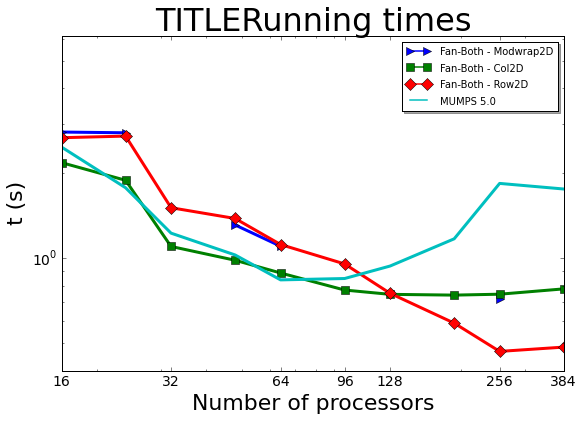

In [44]:



# parse data files
datafile='Results/pwtk/07-27-2015/summary_pull.dat'
datafile2='Results/pwtk/07-27-2015/summary_push.dat'
datapath = os.path.dirname(datafile)
matrixname = 'Pwtk'

print datapath

dt = np.dtype([('p', int), ('col2d_mean', float), ('col2d_median', float), ('col2d_std', float),('row2d_mean', float) ,('row2d_median', float) ,('row2d_std', float) ,('mw2d_mean',float), ('mw2d_median',float), ('mw2d_std',float),('mumps5_mean', float),('mumps5_median', float),('mumps5_std', float)])

data=np.zeros((0,),dt)
data2=np.zeros((0,),dt)

with open(datafile) as f1:
    for line in f1:
        if line[0] != '#':
            line = re.sub(r'[ ]+', r' ', line).upper()
            line_lst = line.rstrip().split(" ")
            #print line_lst
            line_lst = map(float,line_lst)
            line_lst[0:1] = [int(val) for val in line_lst[0:1]]
            
            line_lst = [None if x==-1 else x for x in line_lst]
            
            #print line_lst
            data.resize(data.shape[0]+1)
            data[-1] = tuple(line_lst)
    
    with open(datafile2) as f2:
        for line in f2:
            if line[0] != '#':
                line = re.sub(r'[ ]+', r' ', line).upper()
                line_lst = line.rstrip().split(" ")
                #print line_lst
                line_lst = map(float,line_lst)
                line_lst[0:1] = [int(val) for val in line_lst[0:1]]

                line_lst = [None if x==-1 else x for x in line_lst]

                #print line_lst
                data2.resize(data2.shape[0]+1)
                data2[-1] = tuple(line_lst)
            
         
    PROCS=data['p']
#     MODWRAP2D = data2['mw2d_median']
#     COL2D = data2['col2d_median']
#     ROW2D = data2['row2d_median']
#     MUMPS = data['mumps5_median']
#     COL2DPULL = data['col2d_median']
#     ROW2DPULL = data['row2d_median']
#     MW2DPULL = data['mw2d_median']
    MODWRAP2D = data2['mw2d_mean']
    COL2D = data2['col2d_mean']
    ROW2D = data2['row2d_mean']
    MUMPS = data['mumps5_mean']
    COL2DPULL = data['col2d_mean']
    ROW2DPULL = data['row2d_mean']
    MW2DPULL = data['mw2d_mean']    
    print MW2DPULL

    s1mask = np.isfinite(ROW2DPULL)
    s2mask = np.isfinite(MW2DPULL)
   
    
    #df = pd.DataFrame.from_records(data, index=PROCS, columns=['p', 'mw2d','col2d','row2d','mumps5','diag2d','col2dp','row2dp','mw2dp'])
    #print df
    
    
    #replot into another figure to save the separate thing
    subfig = plt.figure()
    subfig.set_size_inches(9,6)
    ax = subfig.add_subplot(111)
    
    lineMODWRAP2D, = ax.plot(PROCS[s1mask],MODWRAP2D[s1mask], '-',marker='>', markersize=8, linewidth=3, label='Fan-Both - Modwrap2D')
    lineCOL2D, = ax.plot(PROCS[s1mask],COL2D[s1mask], '-',marker='s', markersize=8, linewidth=3, label='Fan-Both - Col2D')
    lineROW2D, = ax.plot(PROCS[s1mask],ROW2D[s1mask], '-',marker='D', markersize=8, linewidth=3, label='Fan-Both - Row2D')
    lineMUMPS, = ax.plot(PROCS[s1mask],MUMPS[s1mask], '-', linewidth=3, label='MUMPS 5.0')
    #lineCOL2DP, = ax.plot(PROCS[s1mask],COL2DPULL[s1mask], '-',marker='s', markersize=8, linewidth=3, label='Pull Fan-Both - Col2D')
    #lineROW2DP, = ax.plot(PROCS[s1mask],ROW2DPULL[s1mask], '-',marker='D', markersize=8, linewidth=3, label='Pull Fan-Both - Row2D')
    #lineMW2DP, = ax.plot(PROCS[s2mask],MW2DPULL[s2mask], '-',marker='>', markersize=8, linewidth=3, label='Pull Fan-Both - ModWrap2D')
    
    #lineDIAG2D, = ax.plot(PROCS,DIAG2D, '--', linewidth=3, label='Fan-Both - Diag2D')
    
    
    ax.set_xticks(PROCS)
    
    ax.set_title('TITLERunning times',fontsize=32)
    ax.set_xlabel('Number of processors',fontsize=22)
    ax.set_ylabel('t (s)',fontsize=22)
    
    maxy = 0
    miny = float("Inf")
    maxy = max( maxy,np.amax(MODWRAP2D[s1mask]),np.amax(COL2D[s1mask]),np.amax(ROW2D[s1mask]),np.amax(MUMPS[s1mask]),np.amax(DIAG2D[s1mask]),np.amax(COL2DPULL[s1mask]),np.amax(ROW2DPULL[s1mask]),np.amax(MW2DPULL[s2mask]) )
    miny = min( miny,np.amin(MODWRAP2D[s1mask]),np.amin(COL2D[s1mask]),np.amin(ROW2D[s1mask]),np.amin(MUMPS[s1mask]),np.amin(DIAG2D[s1mask]),np.amin(COL2DPULL[s1mask]),np.amin(ROW2DPULL[s1mask]),np.amin(MW2DPULL[s2mask]) )    
    
    ax.set_yscale('log',xbase=10)
    ax.set_xscale('log',xbase=2)
    ax.set_ylim([0.4,maxy*0.4])
    ax.set_xlim([16,384])
    
    
    TICKS = [16, 32, 64, 96, 128, 256,384]
    ax.set_xticks(TICKS)
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        

    legend = ax.legend(loc='upper right', shadow=True)
    frame  = legend.get_frame()
    frame.set_facecolor('1')
    
    # Set the fontsize
    for label in legend.get_texts():
            label.set_fontsize(10)
    
    for label in legend.get_lines():
            label.set_linewidth(1.5)  # the legend line width
    
    plt.tick_params(axis='both', which='major', labelsize=14)
        
    subfig.savefig(datapath + '/%s.pdf' % matrixname)
    subfig.savefig(datapath + '/%s.pgf' %matrixname,transparent=True)


In [118]:
def GetStrongScaling(filename,m,size,matrixname):

    matrix = pd.read_csv(filename)
    

    
    #print matrix.columns
    means = matrix.query('m == %d' % m).groupby('p').mean()

    print means

    #stdevs2 = matrix.groupby('p','m','a').std()

    subfig = plt.figure()
    subfig.set_size_inches(9,6)
    ax = subfig.add_subplot(111)

    ax.set_title('Running times for %s %d %d' % (matrixname,m,size),fontsize=25)
    ax.set_xlabel('Core count');
    ax.set_ylabel('Time (s)');



    ax.plot(means.index, means['t'], marker='o', label="Pull", linestyle='-.',linewidth=3)
    ax.plot(means.index, means['ta'], marker='o', label="Pull Async", linestyle='-.',linewidth=3)
    ax.plot(means.index, means['tp'], marker='o', label="Push", linestyle='-.',linewidth=3)
    ax.plot(means.index, means['tpa'], marker='o', label="Push Async", linestyle='-.',linewidth=3)

    
    maxy = 0
    miny = float('Inf')



    maxy = max( maxy,np.amax(means['t']),np.amax(means['ta']),np.amax(means['tp']),np.amax(means['tpa']) )
    miny = min( miny,np.amin(means['t']),np.amin(means['ta']),np.amin(means['tp']),np.amin(means['tpa']) )

    ax.set_ylim([0.5*miny,maxy])

    #ax.set_yscale('log')
    ax.set_xlim([min(list(means.index)),max(list(means.index))])
    ax.set_xscale('log',xbase=2)
    #ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(means.index)
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    # Now add the legend with some customizations.
    legend = ax.legend(loc='upper right', shadow=True, ncol=2)
    #legend = ax.legend(loc='lower center',bbox_to_anchor=(0.5, -0.4), shadow=True,ncol=3)

    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame  = legend.get_frame()
    frame.set_facecolor('1')

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize(15)

    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width

    plt.tick_params(axis='both', which='major', labelsize=14)

    #subfig.savefig('pgf/ss_%s.pgf'%matrixname,transparent=True,additional_artists=legend,bbox_inches="tight")     
    #subfig.savefig('pdf/ss_%s.pdf'%matrixname)

def GetStrongScaling2(filename,filename2,m,size,matrixname):

    matrix = pd.read_csv(filename)
    means = matrix.query('m == %d & s == %d' % (m,size)).groupby(['p','a']).mean()
    pull_serie = means.loc[(means.index.get_level_values('a') ==0)]
    pulla_serie = means.loc[(means.index.get_level_values('a') >0)]
    indx = np.unique(means.index.get_level_values('p'))

    matrix2 = pd.read_csv(filename2)
    means2 = matrix2.query('m == %d & s == %d' % (m,size)).groupby(['p','a']).mean()
    push_serie = means2.loc[(means2.index.get_level_values('a') ==0)]
    pusha_serie = means2.loc[(means2.index.get_level_values('a') >0)]
    indx2 = np.unique(means2.index.get_level_values('p'))

    #stdevs2 = matrix.groupby('p','m','a').std()

    subfig = plt.figure()
    subfig.set_size_inches(9,6)
    ax = subfig.add_subplot(111)

    ax.set_title('Running times for %s %d %d' % (matrixname,m,size),fontsize=25)
    ax.set_xlabel('Core count');
    ax.set_ylabel('Time (s)');



    ax.plot(indx, pull_serie['t'], marker='o', label="Pull", linestyle='-.',linewidth=3)
    ax.plot(indx, pulla_serie['t'], marker='o', label="Pull Async", linestyle='-.',linewidth=3)
    ax.plot(indx2, push_serie['t'], marker='o', label="Push", linestyle='-.',linewidth=3)
    ax.plot(indx2, pusha_serie['t'], marker='o', label="Push Async", linestyle='-.',linewidth=3)
    #ax.plot(means.index, means['tp'], marker='o', label="Push", linestyle='-.',linewidth=3)
    #ax.plot(means.index, means['tpa'], marker='o', label="Push Async", linestyle='-.',linewidth=3)

    
    maxy = 0
    miny = float('Inf')



    #maxy = max( maxy,np.amax(means['t']),np.amax(means['ta']),np.amax(means['tp']),np.amax(means['tpa']) )
    #miny = min( miny,np.amin(means['t']),np.amin(means['ta']),np.amin(means['tp']),np.amin(means['tpa']) )

    #ax.set_ylim([0.5*miny,maxy])

    #ax.set_yscale('log')
    ax.set_xlim([min(list(indx)),max(list(indx))])
    ax.set_xscale('log',xbase=2)
    #ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(indx)
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    # Now add the legend with some customizations.
    legend = ax.legend(loc='lower right', shadow=True, ncol=2)
    #legend = ax.legend(loc='lower center',bbox_to_anchor=(0.5, -0.4), shadow=True,ncol=3)

    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame  = legend.get_frame()
    frame.set_facecolor('1')

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize(15)

    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width

    plt.tick_params(axis='both', which='major', labelsize=14)


    #subfig.savefig('pgf/ss_%s.pgf'%matrixname,transparent=True,additional_artists=legend,bbox_inches="tight")     
    #subfig.savefig('pdf/ss_%s.pdf'%matrixname)


       m  a          t   a2         ta  ap         tp   ap2        tpa
p                                                                     
2    100  0   0.005779  100   0.005890   0   0.004707   100   0.006690
12   100  0   0.075789  100   0.076800   0   0.057320   100   0.060363
24   100  0   0.757686  100   0.743275   0   0.584201   100   1.025810
48   100  0   1.521920  100   1.501400   0   2.069250   100   1.466520
96   100  0   3.085280  100   3.048940   0   2.329380   100   3.138990
128  100  0   4.284500  100   4.560270   0   3.099600   100   3.097100
256  100  0   8.926730  100   8.908490   0   6.318830   100   6.557740
512  100  0  17.308800  100  17.393100   0  12.479200   100  16.472200
      m  a         t   a2        ta  ap       tp   ap2       tpa
p                                                               
128  50  0   2.88785   50   3.74495   0  27.8738    50   2.60599
256  50  0   5.04127   50   4.94029   0  26.6284    50   6.30247
512  50  0  10.28230   50  11.

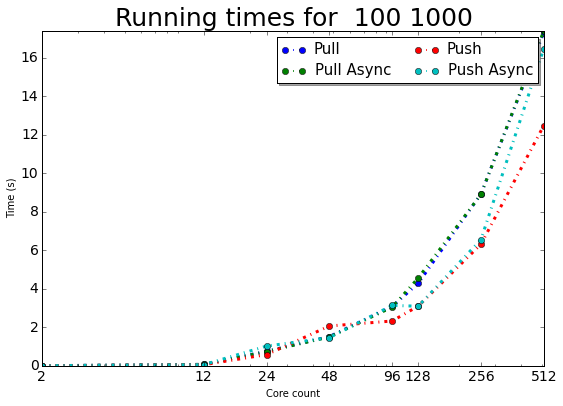

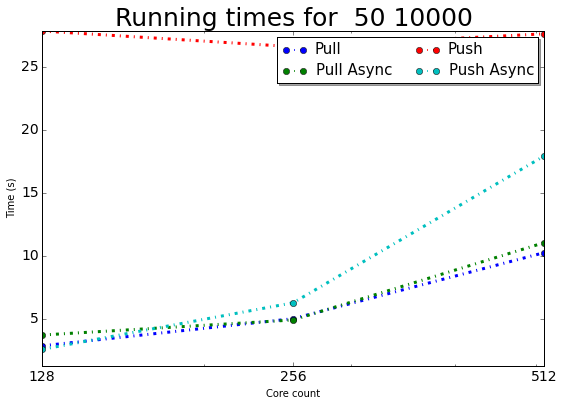

In [60]:
GetStrongScaling('experiments/pull.csv',100,1000,'')
GetStrongScaling('experiments/pull.csv',50,10000,'')

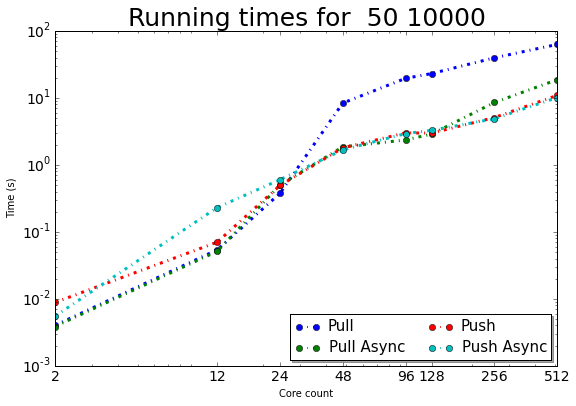

In [109]:
GetStrongScaling2('experiments/pull3.csv','experiments/push3.csv',50,10000,'')

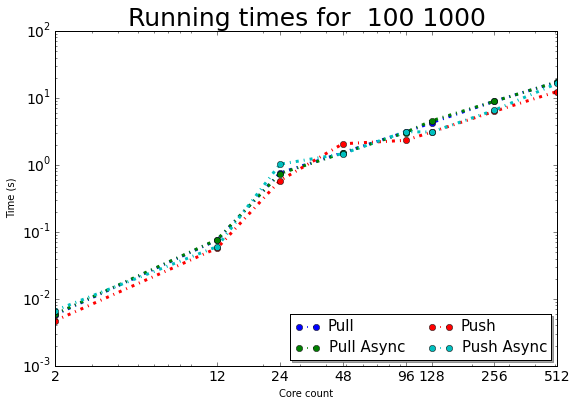

In [110]:
GetStrongScaling2('experiments/pull4.csv','experiments/push4.csv',100,1000,'')

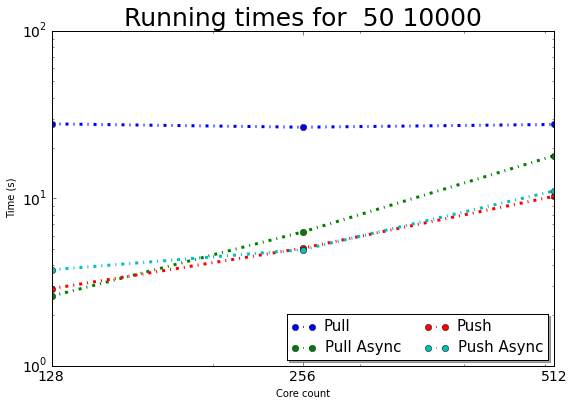

In [112]:
GetStrongScaling2('experiments/pull4.csv','experiments/push4.csv',50,10000,'')

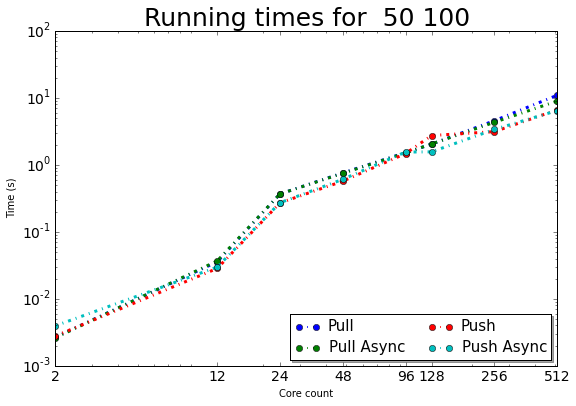

In [116]:
GetStrongScaling2('experiments/pull5.csv','experiments/push5.csv',50,100,'')

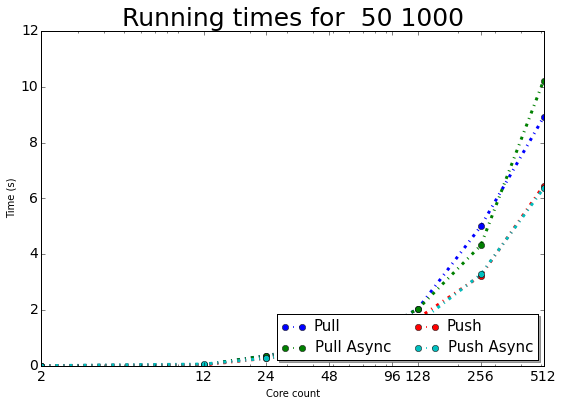

In [120]:
GetStrongScaling2('experiments/pull5.csv','experiments/push5.csv',50,1000,'')

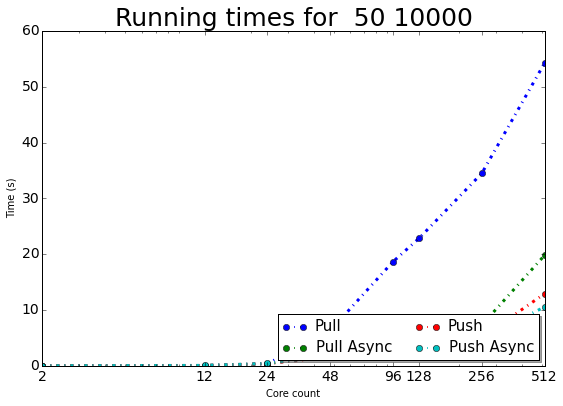

In [119]:
GetStrongScaling2('experiments/pull5.csv','experiments/push5.csv',50,10000,'')